_version log: Considered the pixel size_

In [14]:
from numpy import genfromtxt
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import pandas as pd

beamABroadband = genfromtxt('data\\0307_BB_BA.csv', delimiter=';')
beamBBroadband=genfromtxt('data\\0307_BB_BB.csv', delimiter=';')
fringesBroadband=genfromtxt('data\\0307_fringesBB.csv', delimiter=';')

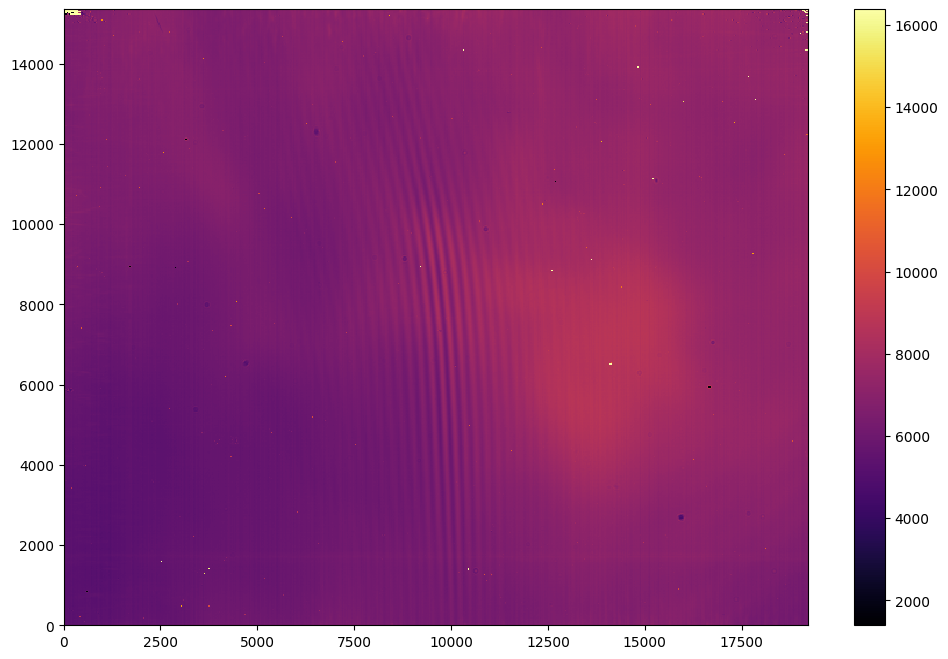

In [15]:
pixel_size = 30 #distance between each pixel in the array in um.

array_length = fringesBroadband.shape[0]
array_height = fringesBroadband.shape[1]

y, x = np.mgrid[0: (array_length+1)*pixel_size: pixel_size, #create a co-ordinate grid for all points in the array
                0: (array_height+1)*pixel_size: pixel_size]

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1, 1, 1)

#im=plt.imshow(fringesBroadband, cmap='inferno')

c = ax.pcolor(x, y, fringesBroadband, cmap='inferno')

plt.colorbar(c)
plt.show()

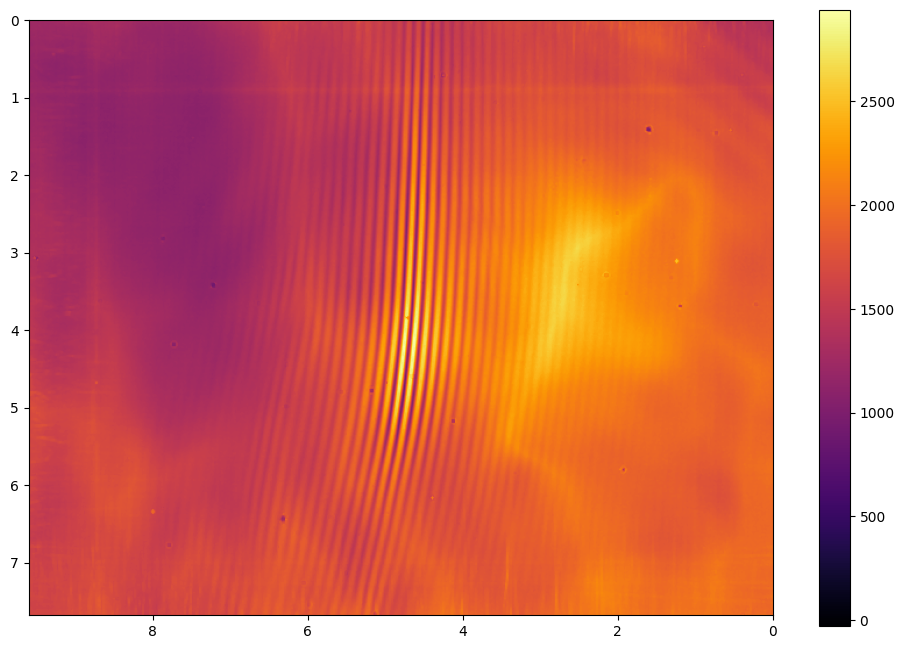

1702.8658264160156


In [16]:
plt.figure(figsize = (12,8))

BeamBackground = np.maximum(beamABroadband, beamBBroadband) #Esimate the background light
#BeamBackground = beamABroadband + beamBBroadband

fringesCOR = ndimage.median_filter(fringesBroadband - BeamBackground, size=2)

im=plt.imshow(fringesCOR[0:490][:490], cmap='inferno', extent=[9.6,0,7.68,0])

plt.colorbar(im)
plt.show()

print(fringesCOR.mean()) #We expect this to be close to 0

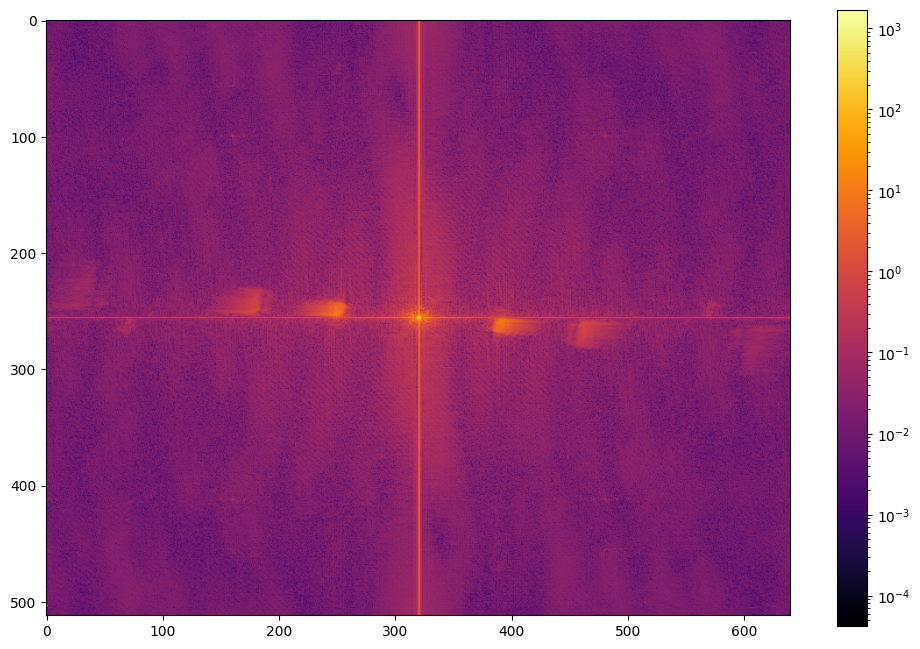

In [17]:
FT = np.fft.fft2(fringesCOR, norm = "forward")
FT = np.fft.fftshift(FT) #rearranges the array such that 0,0 is centred

plt.figure(figsize = (12,8))

im=plt.imshow(np.abs(FT), cmap='inferno', norm = "log")

plt.colorbar(im)
plt.show()

In [99]:
#################FINDING LARGEST AMPLITUDES############

k_x = np.arange(-FT.shape[1]//2, FT.shape[1]//2)
k_y = np.arange(-FT.shape[0]//2, FT.shape[0]//2)
k_x = list(k_x)*FT.shape[0]
k_y = np.repeat(k_y, FT.shape[1])

amplitudes = np.abs(FT.flatten())

def pythagorus(x,y):
    return np.sqrt( (x)**2 +
                    (y)**2)
vpythagorus = np.vectorize(pythagorus)


frequencies = np.stack([amplitudes,
                        k_x,
                        k_y,
                        vpythagorus(k_x, k_y)])
frequencies = np.transpose(frequencies)

frequencies = pd.DataFrame(frequencies, columns = ["amplitude","k_x","k_y","wavenumber"], dtype = float)
frequencies.sort_values("amplitude", ascending = False, inplace = True)
frequencies.reset_index(drop = True, inplace = True)

print(frequencies)

          amplitude    k_x    k_y  wavenumber
0       1771.657990    0.0    0.0    0.000000
1        492.521305    1.0    0.0    1.000000
2        492.521305   -1.0    0.0    1.000000
3        163.729630    2.0    0.0    2.000000
4        163.729630   -2.0    0.0    2.000000
...             ...    ...    ...         ...
327675     0.000116   58.0  180.0  189.113722
327676     0.000086  158.0  236.0  284.007042
327677     0.000086 -158.0 -236.0  284.007042
327678     0.000034  304.0 -170.0  348.304465
327679     0.000034 -304.0  170.0  348.304465

[327680 rows x 4 columns]


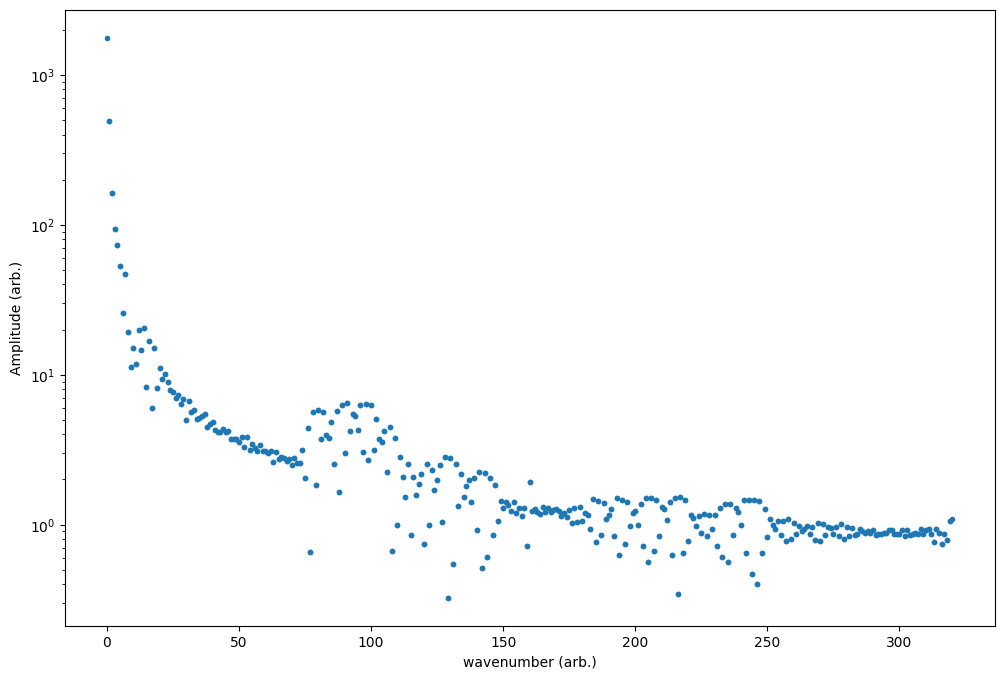

In [119]:
frequencies.sort_values("wavenumber", ascending = True, inplace = True)

plt.figure(figsize = (12,8))

plt.subplot(1, 1, 1)
plt.scatter(frequencies["wavenumber"].where(frequencies["k_y"] == 0),
            frequencies["amplitude"],
            marker = ".")
plt.xlabel('wavenumber (arb.)')
plt.ylabel('Amplitude (arb.)')
plt.yscale("log")

plt.show()